# 사용 패키지

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

In [130]:
# 대회 평가지표
def nmae(true_df, pred_df):
    target_idx = true_df.iloc[:,0]
    pred_df = pred_df[pred_df.iloc[:,0].isin(target_idx)]
    pred_df = pred_df.sort_values(by=[pred_df.columns[0]], ascending=[True])
    true_df = true_df.sort_values(by=[true_df.columns[0]], ascending=[True])
    
    true = true_df.iloc[:,1].to_numpy()
    pred = pred_df.iloc[:,1].to_numpy()
    
    score = np.mean((np.abs(true-pred))/true)
    
    return score

# 데이터 로드

In [3]:
url = 'C:/Users/WIN/Downloads/가스공사/'

In [4]:
total = pd.read_csv(url + '한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')

In [5]:
total.head()

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105


# 전처리

In [6]:
total['구분'].unique()

array(['A', 'B', 'C', 'D', 'E', 'G', 'H'], dtype=object)

In [7]:
# 구분을 순자로 변경
d_map = {}
for i, d in enumerate(total['구분'].unique()):
    d_map[d] = i
total['구분'] = total['구분'].map(d_map)

In [8]:
d_map

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'G': 5, 'H': 6}

In [9]:
total

,연월일,시간,구분,공급량
0,2013-01-01,1,0,2497.129
1,2013-01-01,2,0,2363.265
2,2013-01-01,3,0,2258.505
3,2013-01-01,4,0,2243.969
4,2013-01-01,5,0,2344.105
...,...,...,...,...
368083,2018-12-31,20,6,681.033
368084,2018-12-31,21,6,669.961
368085,2018-12-31,22,6,657.941
368086,2018-12-31,23,6,610.953


In [10]:
total['연월일'] = pd.to_datetime(total['연월일'])

In [11]:
total['year'] = total['연월일'].dt.year
total['month'] = total['연월일'].dt.month
total['day'] = total['연월일'].dt.day
total['weekday'] = total['연월일'].dt.weekday

In [12]:
total

,연월일,시간,구분,공급량,year,month,day,weekday
0,2013-01-01,1,0,2497.129,2013,1,1,1
1,2013-01-01,2,0,2363.265,2013,1,1,1
2,2013-01-01,3,0,2258.505,2013,1,1,1
3,2013-01-01,4,0,2243.969,2013,1,1,1
4,2013-01-01,5,0,2344.105,2013,1,1,1
...,...,...,...,...,...,...,...,...
368083,2018-12-31,20,6,681.033,2018,12,31,0
368084,2018-12-31,21,6,669.961,2018,12,31,0
368085,2018-12-31,22,6,657.941,2018,12,31,0
368086,2018-12-31,23,6,610.953,2018,12,31,0


## 1,2,3월만으로 재구성

In [54]:
mon = total['month'].isin([1,2,3])
total1 = total[mon]
total1

,연월일,시간,구분,공급량,year,month,day,weekday
0,2013-01-01,1,0,2497.129,2013,1,1,1
1,2013-01-01,2,0,2363.265,2013,1,1,1
2,2013-01-01,3,0,2258.505,2013,1,1,1
3,2013-01-01,4,0,2243.969,2013,1,1,1
4,2013-01-01,5,0,2344.105,2013,1,1,1
...,...,...,...,...,...,...,...,...
361483,2018-03-31,20,6,244.162,2018,3,31,5
361484,2018-03-31,21,6,248.059,2018,3,31,5
361485,2018-03-31,22,6,231.181,2018,3,31,5
361486,2018-03-31,23,6,199.022,2018,3,31,5


## 전처리 마무리

In [114]:
# 2018년만 때어서
train_years = [2013,2014,2015,2016,2017]
val_years = [2018]

In [131]:
# 2018년으로 validation set을 생성
train = total1[total1['year'].isin(train_years)]
val = total1[total1['year'].isin(val_years)]

In [132]:
train

,연월일,시간,구분,공급량,year,month,day,weekday
0,2013-01-01,1,0,2497.129,2013,1,1,1
1,2013-01-01,2,0,2363.265,2013,1,1,1
2,2013-01-01,3,0,2258.505,2013,1,1,1
3,2013-01-01,4,0,2243.969,2013,1,1,1
4,2013-01-01,5,0,2344.105,2013,1,1,1
...,...,...,...,...,...,...,...,...
300163,2017-03-31,20,6,382.636,2017,3,31,4
300164,2017-03-31,21,6,379.556,2017,3,31,4
300165,2017-03-31,22,6,353.684,2017,3,31,4
300166,2017-03-31,23,6,318.756,2017,3,31,4


In [134]:
features = ['구분', 'month', 'day', 'weekday', '시간']
train_x = train[features]
train_y = train['공급량']

val_x = val[features]
val_y = val['공급량']

In [135]:
train_x

,구분,month,day,weekday,시간
0,0,1,1,1,1
1,0,1,1,1,2
2,0,1,1,1,3
3,0,1,1,1,4
4,0,1,1,1,5
...,...,...,...,...,...
300163,6,3,31,4,20
300164,6,3,31,4,21
300165,6,3,31,4,22
300166,6,3,31,4,23


In [136]:
train_y

0         2497.129
1         2363.265
2         2258.505
3         2243.969
4         2344.105
            ...   
300163     382.636
300164     379.556
300165     353.684
300166     318.756
300167     294.940
Name: 공급량, Length: 75768, dtype: float64

# 학습

## 기본 LGBM 모델

In [173]:
d_train = lgb.Dataset(train_x, train_y)
d_val = lgb.Dataset(val_x, val_y)

params = {
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

model = lgb.train(params, d_train, 500, d_val, verbose_eval=20, early_stopping_rounds=50)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 75
[LightGBM] [Info] Number of data points in the train set: 75768, number of used features: 5
[LightGBM] [Info] Start training from score 1539.324886
Training until validation scores don't improve for 50 rounds
[20]	valid_0's l1: 343.263
[40]	valid_0's l1: 278.069
[60]	valid_0's l1: 263.963
[80]	valid_0's l1: 259.567
[100]	valid_0's l1: 258.498
[120]	valid_0's l1: 257.487
[140]	valid_0's l1: 259.921
[160]	valid_0's l1: 260.794
Early stopping, best iteration is:
[126]	valid_0's l1: 257.202


C:\Users\WIN\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\WIN\anaconda3\lib\site-packages\lightgbm\engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


In [174]:
pre = model.predict(val_x)
pre

array([1848.41971502, 1660.21747756, 1580.79778636, ...,  422.84451122,
        398.89897323,  364.58076495])

In [175]:
# 평가지표 활용
nmae( pd.DataFrame(val_y).reset_index(drop=True).reset_index() , pd.DataFrame(pre).reset_index())

0.16689029228933744

## KNNR 모델

In [164]:
# 기본
# 1K값을 바꾸어도 결과는 같음 ㅋㅋㅋ
from sklearn.neighbors import KNeighborsRegressor

# 모델 훈련
model = KNeighborsRegressor(n_neighbors=5, weights='distance', p=1, n_jobs=-1) #601
model.fit(train_x, train_y)

KNeighborsRegressor(n_jobs=-1, p=1, weights='distance')

In [165]:
pre = model.predict(val_x)
pre

array([1846.558   , 1782.049   , 1661.4015  , ...,  681.109125,
        347.398   ,  323.415   ])

In [171]:
# 평가지표 활용
nmae( pd.DataFrame(val_y).reset_index(drop=True).reset_index() , pd.DataFrame(pre).reset_index())

0.1810682444276462

## 딥러닝 저장 메소드

In [356]:
# 모델 저장하기
from keras.models import load_model

model.save(url + 'DeepL_1020_3.h5')

In [ ]:
# 모델 불러오기
from keras.models import load_model

new_model = load_model(url + 'DeepL_1020_1.h5')

## 기본 딥러닝

In [176]:
train_x

,구분,month,day,weekday,시간
0,0,1,1,1,1
1,0,1,1,1,2
2,0,1,1,1,3
3,0,1,1,1,4
4,0,1,1,1,5
...,...,...,...,...,...
300163,6,3,31,4,20
300164,6,3,31,4,21
300165,6,3,31,4,22
300166,6,3,31,4,23


In [267]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(5,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='relu'))

In [353]:
import tensorflow as tf 

model.compile(#optimizer='adam',
             optimizer= tf.optimizers.Adam(lr=0.0000001, beta_1=0.9, beta_2=0.999) ,
             loss='mean_absolute_error',
             metrics=['mae', 'mse'])

C:\Users\WIN\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [361]:
history = model.fit(train_x, train_y, epochs=30, batch_size=64)

Epoch 1/30
1184/1184 [==============================] - 1s 855us/step - loss: 150.5961 - mae: 150.5961 - mse: 61418.5234
Epoch 2/30
1184/1184 [==============================] - 1s 829us/step - loss: 150.5960 - mae: 150.5960 - mse: 61444.8047
Epoch 3/30
1184/1184 [==============================] - 1s 835us/step - loss: 150.5937 - mae: 150.5937 - mse: 61431.9062
Epoch 4/30
1184/1184 [==============================] - 1s 835us/step - loss: 150.5941 - mae: 150.5941 - mse: 61424.5391
Epoch 5/30
1184/1184 [==============================] - 1s 831us/step - loss: 150.5937 - mae: 150.5937 - mse: 61422.1680
Epoch 6/30
1184/1184 [==============================] - 1s 843us/step - loss: 150.5925 - mae: 150.5925 - mse: 61434.9180
Epoch 7/30
1184/1184 [==============================] - 1s 850us/step - loss: 150.5943 - mae: 150.5943 - mse: 61437.5195
Epoch 8/30
1184/1184 [==============================] - 1s 845us/step - loss: 150.5950 - mae: 150.5950 - mse: 61424.1406
Epoch 9/30
1184/1184 [==========

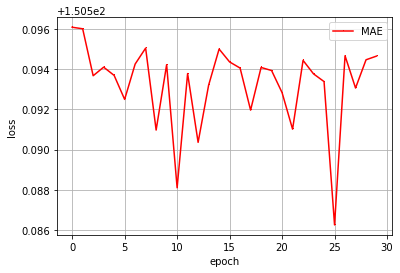

In [362]:
# 모델 loss 그래프

fit_loss = history.history['mae']
# fit_loss2 = history.history['mse']

x_len = np.arange(len(fit_loss))
plt.plot(x_len, fit_loss, marker=',', c='red', label='MAE')
# plt.plot(x_len, fit_loss2, marker=',', c='blue', label='MSE')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [128]:
pre = model.predict(val_x)
pre

array([[1850.1632 ],
       [1998.029  ],
       [2154.036  ],
       ...,
       [ 784.89166],
       [ 816.3546 ],
       [ 847.8181 ]], dtype=float32)

In [ ]:
d_train = lgb.Dataset(train_x, train_y)
d_val = lgb.Dataset(val_x, val_y)

params = {
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

model = lgb.train(params, d_train, 500, d_val, verbose_eval=20, early_stopping_rounds=10)

# 추론 및 결과 제출

In [30]:
test = pd.read_csv(url + 'test.csv')
submission = pd.read_csv(url + 'sample_submission.csv')

In [31]:
test.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [32]:
submission.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0


In [33]:
test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]

In [34]:
test

,일자|시간|구분,일자,시간,구분
0,2019-01-01 01 A,2019-01-01,1,A
1,2019-01-01 02 A,2019-01-01,2,A
2,2019-01-01 03 A,2019-01-01,3,A
3,2019-01-01 04 A,2019-01-01,4,A
4,2019-01-01 05 A,2019-01-01,5,A
...,...,...,...,...
15115,2019-03-31 20 H,2019-03-31,20,H
15116,2019-03-31 21 H,2019-03-31,21,H
15117,2019-03-31 22 H,2019-03-31,22,H
15118,2019-03-31 23 H,2019-03-31,23,H


In [35]:
test['일자'] = pd.to_datetime(test['일자'])
test['year'] = test['일자'].dt.year
test['month'] = test['일자'].dt.month
test['day'] = test['일자'].dt.day
test['weekday'] = test['일자'].dt.weekday

In [36]:
test

,일자|시간|구분,일자,시간,구분,year,month,day,weekday
0,2019-01-01 01 A,2019-01-01,1,A,2019,1,1,1
1,2019-01-01 02 A,2019-01-01,2,A,2019,1,1,1
2,2019-01-01 03 A,2019-01-01,3,A,2019,1,1,1
3,2019-01-01 04 A,2019-01-01,4,A,2019,1,1,1
4,2019-01-01 05 A,2019-01-01,5,A,2019,1,1,1
...,...,...,...,...,...,...,...,...
15115,2019-03-31 20 H,2019-03-31,20,H,2019,3,31,6
15116,2019-03-31 21 H,2019-03-31,21,H,2019,3,31,6
15117,2019-03-31 22 H,2019-03-31,22,H,2019,3,31,6
15118,2019-03-31 23 H,2019-03-31,23,H,2019,3,31,6


In [37]:
test['구분'].map

<bound method Series.map of 0        A
1        A
2        A
3        A
4        A
        ..
15115    H
15116    H
15117    H
15118    H
15119    H
Name: 구분, Length: 15120, dtype: object>

In [38]:
test['구분'] = test['구분'].map(d_map)

In [39]:
test_x = test[features]

In [40]:
test_x

,구분,month,day,weekday,시간
0,0,1,1,1,1
1,0,1,1,1,2
2,0,1,1,1,3
3,0,1,1,1,4
4,0,1,1,1,5
...,...,...,...,...,...
15115,6,3,31,6,20
15116,6,3,31,6,21
15117,6,3,31,6,22
15118,6,3,31,6,23


In [167]:
preds = model.predict(test_x)
# preds = new_model.predict(test_x)

In [168]:
preds

array([2497.129, 2363.265, 2258.505, ...,  411.892,  376.14 ,  348.348])

In [169]:
submission['공급량'] = preds

In [170]:
submission.to_csv(url + 'KNNRR.csv', index=False)